© [Mariia Seleznova](https://www.ai.math.uni-muenchen.de/members/postdocs/mariia-seleznova/index.html), 2025. [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/).

# 📦 Homework 4 — Mini-batch SGD

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

## Load the data

We load the data manually from the UCI repository [page of HTRU2 dataset](https://archive.ics.uci.edu/dataset/372/htru2). After unpacking, the data folder contains a `.csv` version and an `.arff` version of the file with the dataset table, and a readme file with dataset description. Since we already know how to deal with csv files, we'll use this version.

In [2]:
file_name = 'htru2/HTRU_2.csv'
# Column names are taken from the data description
column_names = ['Profile_mean', 'Profile_stdev', 'Profile_skewness', 'Profile_kurtosis',
                'DM_mean', 'DM_stdev', 'DM_skewness', 'DM_kurtosis', 'class']  

print(f'Loading data from local file `{file_name}`...')
df = pd.read_csv(file_name, names=column_names)
print('Done.')

Loading data from local file `htru2/HTRU_2.csv`...
Done.


In [3]:
df

,Profile_mean,Profile_stdev,Profile_skewness,Profile_kurtosis,DM_mean,DM_stdev,DM_skewness,DM_kurtosis,class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0
...,...,...,...,...,...,...,...,...,...
17893,136.429688,59.847421,-0.187846,-0.738123,1.296823,12.166062,15.450260,285.931022,0
17894,122.554688,49.485605,0.127978,0.323061,16.409699,44.626893,2.945244,8.297092,0
17895,119.335938,59.935939,0.159363,-0.743025,21.430602,58.872000,2.499517,4.595173,0
17896,114.507812,53.902400,0.201161,-0.024789,1.946488,13.381731,10.007967,134.238910,0


In [4]:
df.dtypes

Profile_mean        float64
Profile_stdev       float64
Profile_skewness    float64
Profile_kurtosis    float64
DM_mean             float64
DM_stdev            float64
DM_skewness         float64
DM_kurtosis         float64
class                 int64
dtype: object

### Assign class labels

The original class labels in the dataset are 0 and 1. To be consisten with our binary classification setup, we replace the class labels with  -1 and 1.

In [5]:
df['class'] = df['class'].replace([0, 1], [-1, 1])

### Convert to Numpy

In [6]:
X = df.iloc[:,df.columns != 'class'].to_numpy()
Y = df.iloc[:,df.columns == 'class'].to_numpy().ravel()

## Mini-batch SGD classifier

We create `SGDClassifier` class.

In [7]:
class LinearBinaryClassification:
    """
    Linear binary classification class.

    Stores a linear classification model with parameters (w,b)
    and decision function h(x) = sign(w @ x + b)

    Parameters:
    ----------
    w: array
    b: array

    """
    def __init__(self, w, b):
        self.w = w
        self.b = b

    def decision_function(self, x):
        return x @ self.w + self.b
    
    def compute_metrics(self, X, Y, metrics_dict):
        """
        Compute metrics 

        Parameters:
        ----------
        X: array
          Features matrix 
        Y: array
          Labels vector
        metrics_dict: dict
          Dictionary with metric names as keys and
          functions to comoute metrics as values

          The expected syntax of a metric function is metric(y_pred, y_true) 
        
        Returns:
        -------
        metrics: dict
          Dictionary of current metric values
        """
        metrics = {}
        for metric_name in metrics_dict:
            metrics[metric_name] = metrics_dict[metric_name](self.decision_function(X),Y)
        return metrics
    
    def __call__(self, x):
        # Numpy's `where` function provides a fast substitution
        return np.where(self.decision_function(x) >= 0.0, 1, -1)
    
class SGDClassifier(LinearBinaryClassification):
    """
    Gradient descent binary classifier
    """
    
    def loss_grad(self, X,Y):
        """Loss gradient"""
        residual = self.decision_function(X) - Y
        w_grad = X.T@residual/X.shape[0]
        b_grad = np.mean(residual, axis=0)
        return w_grad, b_grad
    
    def update(self, X, Y, lr = 1e-3):
        """
        Single step of mini-batch SGD

        Parameters:
        ----------
        X: array
          Features matrix (batch)
        Y: array
          Labels vector (batch)
        lr: float
          Learning rate
        """
        grad_w, grad_b = self.loss_grad(X,Y)
        self.w -= lr*grad_w
        self.b -= lr*grad_b

                   
    def fit(self, X, Y, lr = 1e-3, num_epochs = 10, batch_size=100, compute_metrics=False, metrics_dict=None):
        """Mini-batch SGD training loop"""
        if compute_metrics:
            metrics_history = {metric_name:[] for metric_name in metrics_dict}

            metrics = self.compute_metrics(X,Y,metrics_dict)
            for metric_name in metrics_dict:
              metrics_history[metric_name].append(metrics[metric_name])
        else:
            metrics_history = None

        for _ in range(num_epochs):
           
            perm_index = np.random.permutation(np.arange(X.shape[0]))
            n_batches = np.ceil(X.shape[0]/batch_size)
            batch_indices = np.array_split(perm_index,n_batches)
            
            for ind in batch_indices:
                self.update(X[ind],Y[ind],lr)

                if compute_metrics:
                    metrics = self.compute_metrics(X,Y,metrics_dict)
                    for metric_name in metrics_dict:
                        metrics_history[metric_name].append(metrics[metric_name])
            
        return self.w, self.b, metrics_history



### 🛠️ Metrics tracking 

📌 Our implementation includes a possibility to **compute arbitrary metrics** during training via the `compute_metrics` method. This method evaluates the current model state using metric functions defined **externally** to the class, making the metric logic modular and reusable.

📌 The `fit` method includes a boolean argument `compute_metrics`. When set to `True`, the model computes and stores the specified metrics from `metrics_dict` at each training step. Being able to toggle this feature is helpful, as storing the full training history can become costly during long training runs. In this notebook, however, keeping the history is particularly beneficial, as it allows us to compute learning curves seamlessly—without rewriting the training logic outside the class (as we had to do in the lecture notebook).

Following the logic of this setup, we define our metrics of interest outside of the class and form a metrics dictionary:

In [8]:
def accuracy(y_pred,y_true):
    pred_labels = np.where(y_pred >= 0.0, 1, -1)
    return np.mean(pred_labels == y_true)*100

def mean_squared_error(y_pred,y_true):
    """Loss function"""
    return 0.5*np.mean((y_pred - y_true)**2, axis=0)

metrics_dict = {'accuracy': accuracy,
                'loss':     mean_squared_error}

### Setting 1: Fixed number of epochs

We compare the behaviour of SGD with different batch sizes for training with a fixed number of epochs.

We will use Python's build-in `time` module to measure how long the fitting takes.

In [9]:
import time

In [10]:
batch_sizes = [1,10,100,1000,2000,X.shape[0]]

num_epochs = 10
# We choose small learning rate to ensure that full-batch GD does not zigzag too much
learning_rate = 1e-5

history = {}

for batch_size in batch_sizes:

    w = np.array([0.]*X.shape[1])
    b = 0.
    model = SGDClassifier(w, b)

    print(f"Steps per epoch for batch size {batch_size}: {X.shape[0]//batch_size}")

    start = time.time()
    _,_, metrics_history = model.fit(X, Y, 
                                     lr = learning_rate, 
                                     num_epochs = num_epochs, 
                                     batch_size = batch_size, 
                                     compute_metrics = True, 
                                     metrics_dict = metrics_dict)
    end = time.time()

    print(f"⏱️ Elapsed time for {num_epochs} epochs: {end - start:.4f} seconds\n")

    history[batch_size] = metrics_history

Steps per epoch for batch size 1: 17898
⏱️ Elapsed time for 10 epochs: 39.5036 seconds

Steps per epoch for batch size 10: 1789
⏱️ Elapsed time for 10 epochs: 3.5334 seconds

Steps per epoch for batch size 100: 178
⏱️ Elapsed time for 10 epochs: 0.3581 seconds

Steps per epoch for batch size 1000: 17
⏱️ Elapsed time for 10 epochs: 0.0425 seconds

Steps per epoch for batch size 2000: 8
⏱️ Elapsed time for 10 epochs: 0.0257 seconds

Steps per epoch for batch size 17898: 1
⏱️ Elapsed time for 10 epochs: 0.0098 seconds



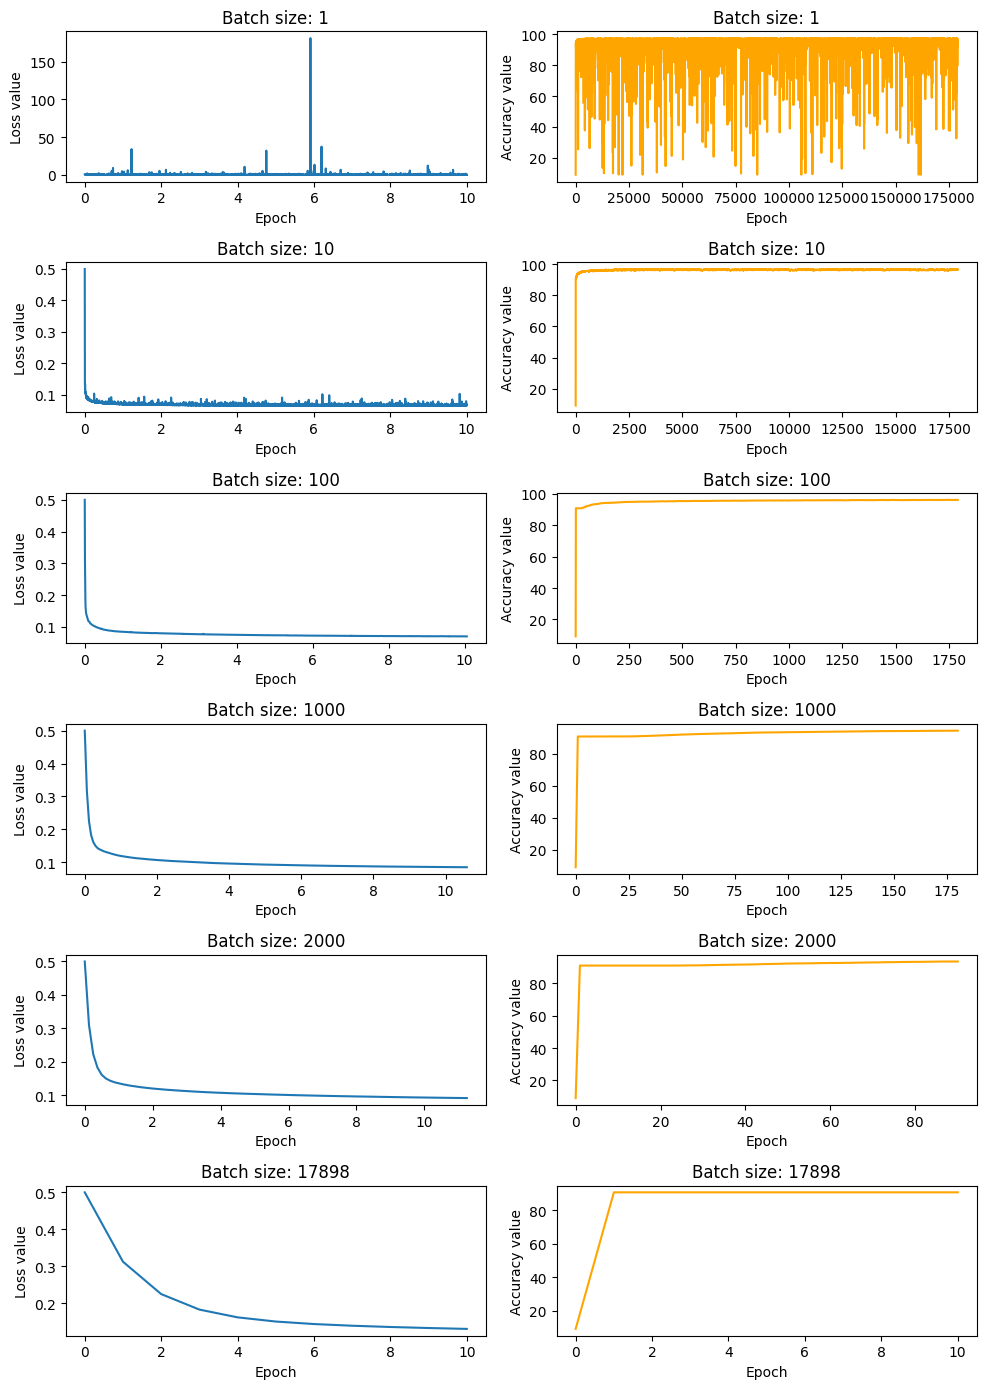

In [11]:
fig, ax = plt.subplots(len(batch_sizes),2, figsize=(10,14))

for batch_size, ax_ in zip(batch_sizes, ax):

    ax_[0].plot(history[batch_size]['loss'])
    ax_[1].plot(history[batch_size]['accuracy'], color='orange')

    ax_[0].set_xlabel('Epoch')
    ax_[1].set_xlabel('Epoch')

    ax_[0].set_title(f'Batch size: {batch_size}')
    ax_[1].set_title(f'Batch size: {batch_size}')

    ax_[0].set_ylabel('Loss value')
    ax_[1].set_ylabel('Accuracy value')

    
    upd_per_epoch = int(X.shape[0]/batch_size)
    epochs_ind = np.array(range(0,len(history[batch_size]['loss']),2*upd_per_epoch))
    epochs_num = epochs_ind/upd_per_epoch
    
    ax_[0].set_xticks(epochs_ind,epochs_num.astype(int))
      
fig.tight_layout()

We can make three observations from the results:
- **Computation time:** Training with smaller batch sizes takes more time for fixed number of epochs. While every iteration is cheaper, the number of steps can be much larger for small batch sizes. 
- **Stability:** Very small batch sizes result in a lot of noise in the updates. 
- **Convergence:** Smaller batch sizes yield faster convergence (unless it's obsured by the noise). In this particular setting, full-batch SGD doesn't reach final accuracy value in 10 epochs, while all th other batch sizes converge.

These observations suggest that there is a **trade-off** between stability and convergence time in choosing the batch size. 

### Setting 2: Fixed number of training steps

Now we compare the training in a setting where the number of steps is fixed, and the number of epochs varies according to the batch size.

In [12]:
num_steps = X.shape[0]
history = {}

for batch_size in batch_sizes:

    w = np.array([0.]*X.shape[1])
    b = 0.
    model = SGDClassifier(w, b)

    num_steps_per_epoch = X.shape[0]//batch_size
    num_epochs = num_steps//num_steps_per_epoch

    print(f"Epochs for {num_steps} steps: {num_epochs}")

    start = time.time()
    _,_, metrics_history = model.fit(X, Y, 
                                     lr = learning_rate, 
                                     num_epochs = num_epochs, 
                                     batch_size = batch_size, 
                                     compute_metrics = True, 
                                     metrics_dict = metrics_dict)
    end = time.time()

    print(f"⏱️ Elapsed time for {num_steps} steps: {end - start:.4f} seconds\n")

    history[batch_size] = metrics_history

Epochs for 17898 steps: 1
⏱️ Elapsed time for 17898 steps: 3.5429 seconds

Epochs for 17898 steps: 10
⏱️ Elapsed time for 17898 steps: 3.6565 seconds

Epochs for 17898 steps: 100
⏱️ Elapsed time for 17898 steps: 3.4279 seconds

Epochs for 17898 steps: 1052
⏱️ Elapsed time for 17898 steps: 4.4342 seconds

Epochs for 17898 steps: 2237
⏱️ Elapsed time for 17898 steps: 5.4835 seconds

Epochs for 17898 steps: 17898
⏱️ Elapsed time for 17898 steps: 16.6358 seconds



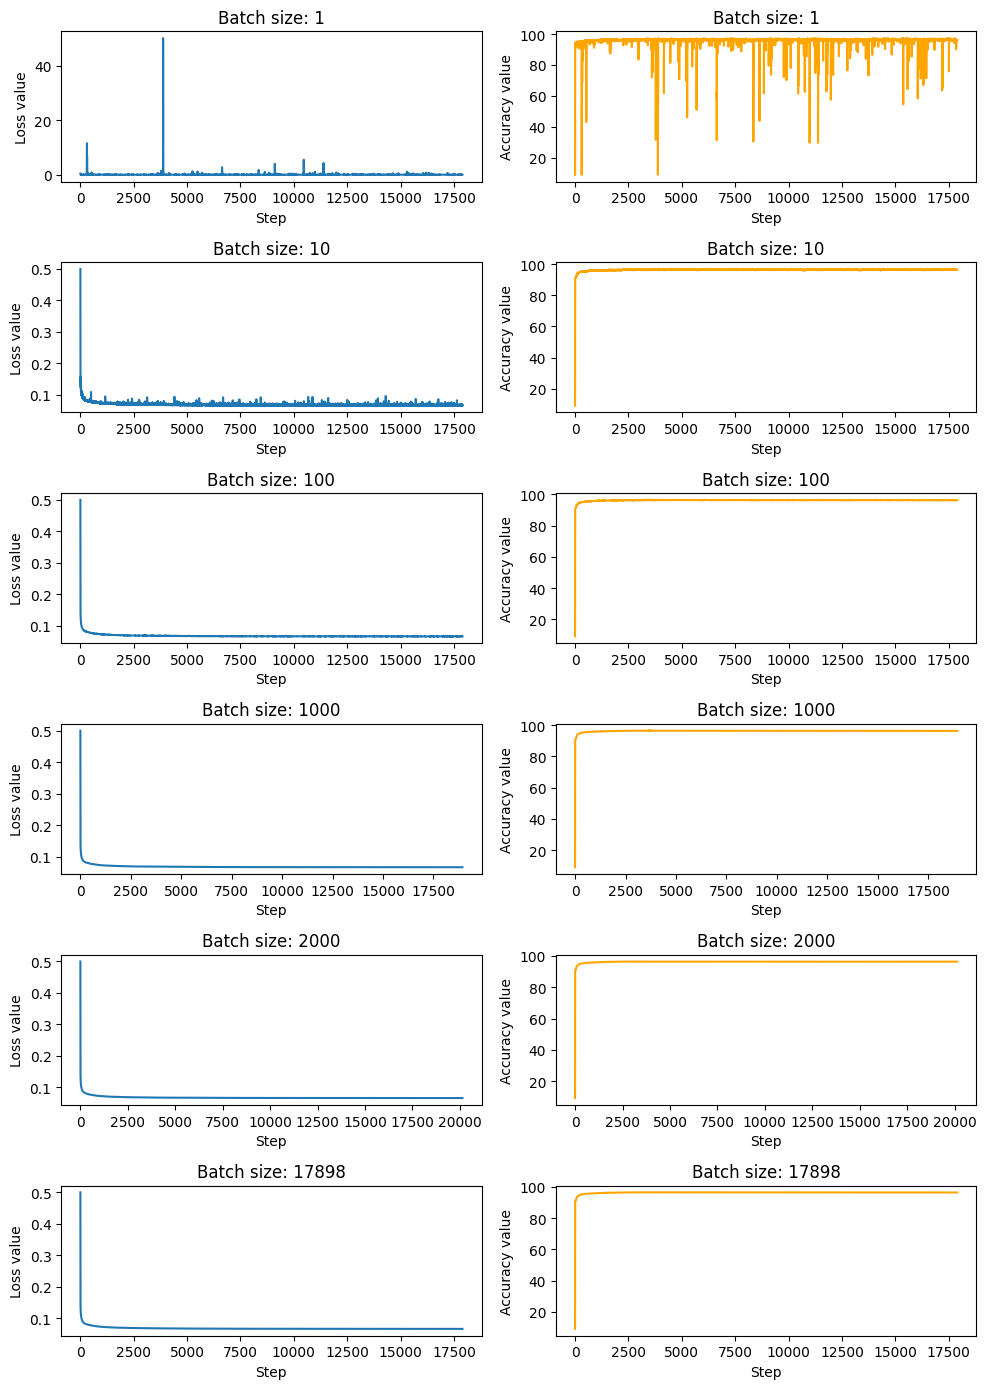

In [13]:
fig, ax = plt.subplots(len(batch_sizes),2, figsize=(10,14))

for batch_size, ax_ in zip(batch_sizes, ax):

    ax_[0].plot(history[batch_size]['loss'])
    ax_[1].plot(history[batch_size]['accuracy'], color='orange')

    ax_[0].set_xlabel('Step')
    ax_[1].set_xlabel('Step')

    ax_[0].set_title(f'Batch size: {batch_size}')
    ax_[1].set_title(f'Batch size: {batch_size}')

    ax_[0].set_ylabel('Loss value')
    ax_[1].set_ylabel('Accuracy value')
  
fig.tight_layout()

This setting makes it clear that the computation time **per iteration** is indeed shorter for smaller batch sizes. 

### 🛠️ Learning rate 

📌 Recall the discussion of the importance of learning rate and the relationship to quadratic form matrix condition number from the lecture. If we check the condition number of the Hessian of the problem we are solving here, we see that we are in a pretty bad situation:

In [14]:
np.linalg.cond(X.T@X)

np.float64(662408.7548530733)

This explains why it's hard to avoid instability even during the full-batch GD training.

📌 We will speak about how to deal with this problem later in the course, but you can start thinking about it now.
